# Validação de modelos de clusterização

## Projeto da disciplina - Entrega final

### Aluno: Rafael Lima Paulo

#### Link para o github: https://github.com/ralima/projeto-final-validacao-modelos-clusterizacao

## Parte 1: Infraestrutura

### Instruções

Para criação do ambimente virtual execute os comandos a seguir:

* Criação do ambiente virtual com Anaconda:
`conda create -n cluster_env python=3.9`

* Ativação do ambiente:
`conda activate cluster_env`

* Instalação dos pacotes necessários:
`!pip install -r requirements.txt`


In [44]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3566 sha256=42d4757c843957e25d7cb60ac91b07501b3cda1e025682a752f0b5bee132e287
  Stored in directory: /Users/rafael/Library/Caches/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


### Descrição do ambiente

In [2]:
!conda info --envs

# conda environments:
#
base                     /opt/anaconda3
cluster_env           *  /opt/anaconda3/envs/cluster_env
ml_eng                   /opt/anaconda3/envs/ml_eng



In [3]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.9.20 (main, Oct  3 2024, 02:27:54) 
[Clang 14.0.6 ]


In [4]:
import platform
print(f"System: {platform.system()}")
print(f"Node: {platform.node()}")
print(f"Release: {platform.release()}")
print(f"Version: {platform.version()}")
print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")


System: Darwin
Node: Rafaels-MacBook-Pro-2.local
Release: 22.6.0
Version: Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:56 PDT 2023; root:xnu-8796.141.3~6/RELEASE_X86_64
Machine: x86_64
Processor: i386


## Parte 2: Escolha de base de dados

### Descrição da base escolhida

A base [**Credit Card Dataset for Clustering**](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata), foi escolhida por sua relevância no contexto de segmentação de clientes no setor financeiro. Abaixo estão os principais motivos para essa escolha:

 1. Contexto Real de Negócio:
    - Os dados refletem o comportamento de uso de cartões de crédito, uma aplicação comum e prática em problemas de clusterização.
    - A análise permite identificar perfis de clientes para estratégias de marketing, personalização de produtos e gestão de risco.
 2. Diversidade de Variáveis
    - Com 18 variáveis comportamentais, os dados abrangem aspectos como frequência de compras, valores transacionados, adiantamento em dinheiro e limites de crédito.
    - Essa diversidade viabiliza a análise de múltiplas dimensões do comportamento financeiro dos clientes.
 3. Objetivos da Análise:
    - **Segmentar Clientes:** Agrupar indivíduos com padrões de uso similares.
    - **Apoiar Decisões Estratégicas:** Fornecer insights para campanhas direcionadas e criação de produtos financeiros personalizados.
    - **Identificar Padrões de Consumo:** Explorar hábitos financeiros para melhorar a compreensão do perfil de cada segmento.

### Leitura e Análise da base de dados

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances, silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from math import pi

from fastdtw import fastdtw

from sklearn.impute import SimpleImputer

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

In [6]:
# Carregar o dataset
df = pd.read_csv('CC-GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### Estrutura dos Dados

O conjunto de dados possui 18 colunas e 8.950 linhas, sendo que a coluna CUST_ID é um identificador e não será usada na clusterização. As demais colunas representam variáveis numéricas e contínuas relevantes para a segmentação de clientes.

In [9]:
# Contar valores ausentes em cada coluna
missing_values = df.isnull().sum()
print("Valores ausentes:\n", missing_values)


Valores ausentes:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


#### Valores Ausentes
- A coluna `CREDIT_LIMIT` possui 1 valor ausente.
- A coluna `MINIMUM_PAYMENTS` possui 313 valores ausentes.

### Análise de faixa dinâmica das variáveis

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

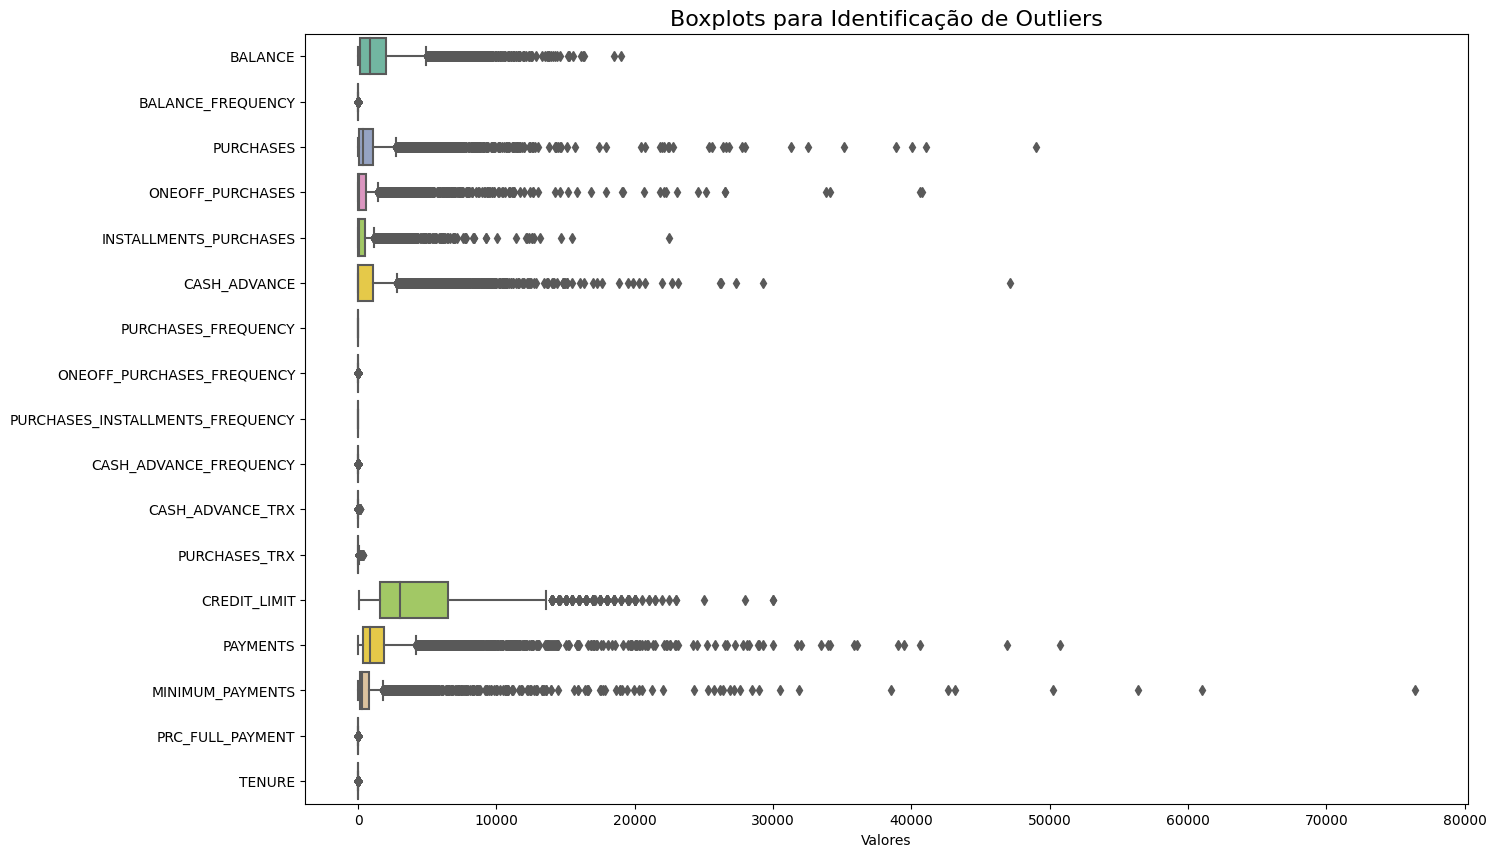

In [10]:
# Seleção de variáveis numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Estatísticas descritivas
print(df.describe())

# Visualização de outliers com boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[numeric_columns], orient="h", palette="Set2")
plt.title("Boxplots para Identificação de Outliers", fontsize=16)
plt.xlabel("Valores")
plt.show()

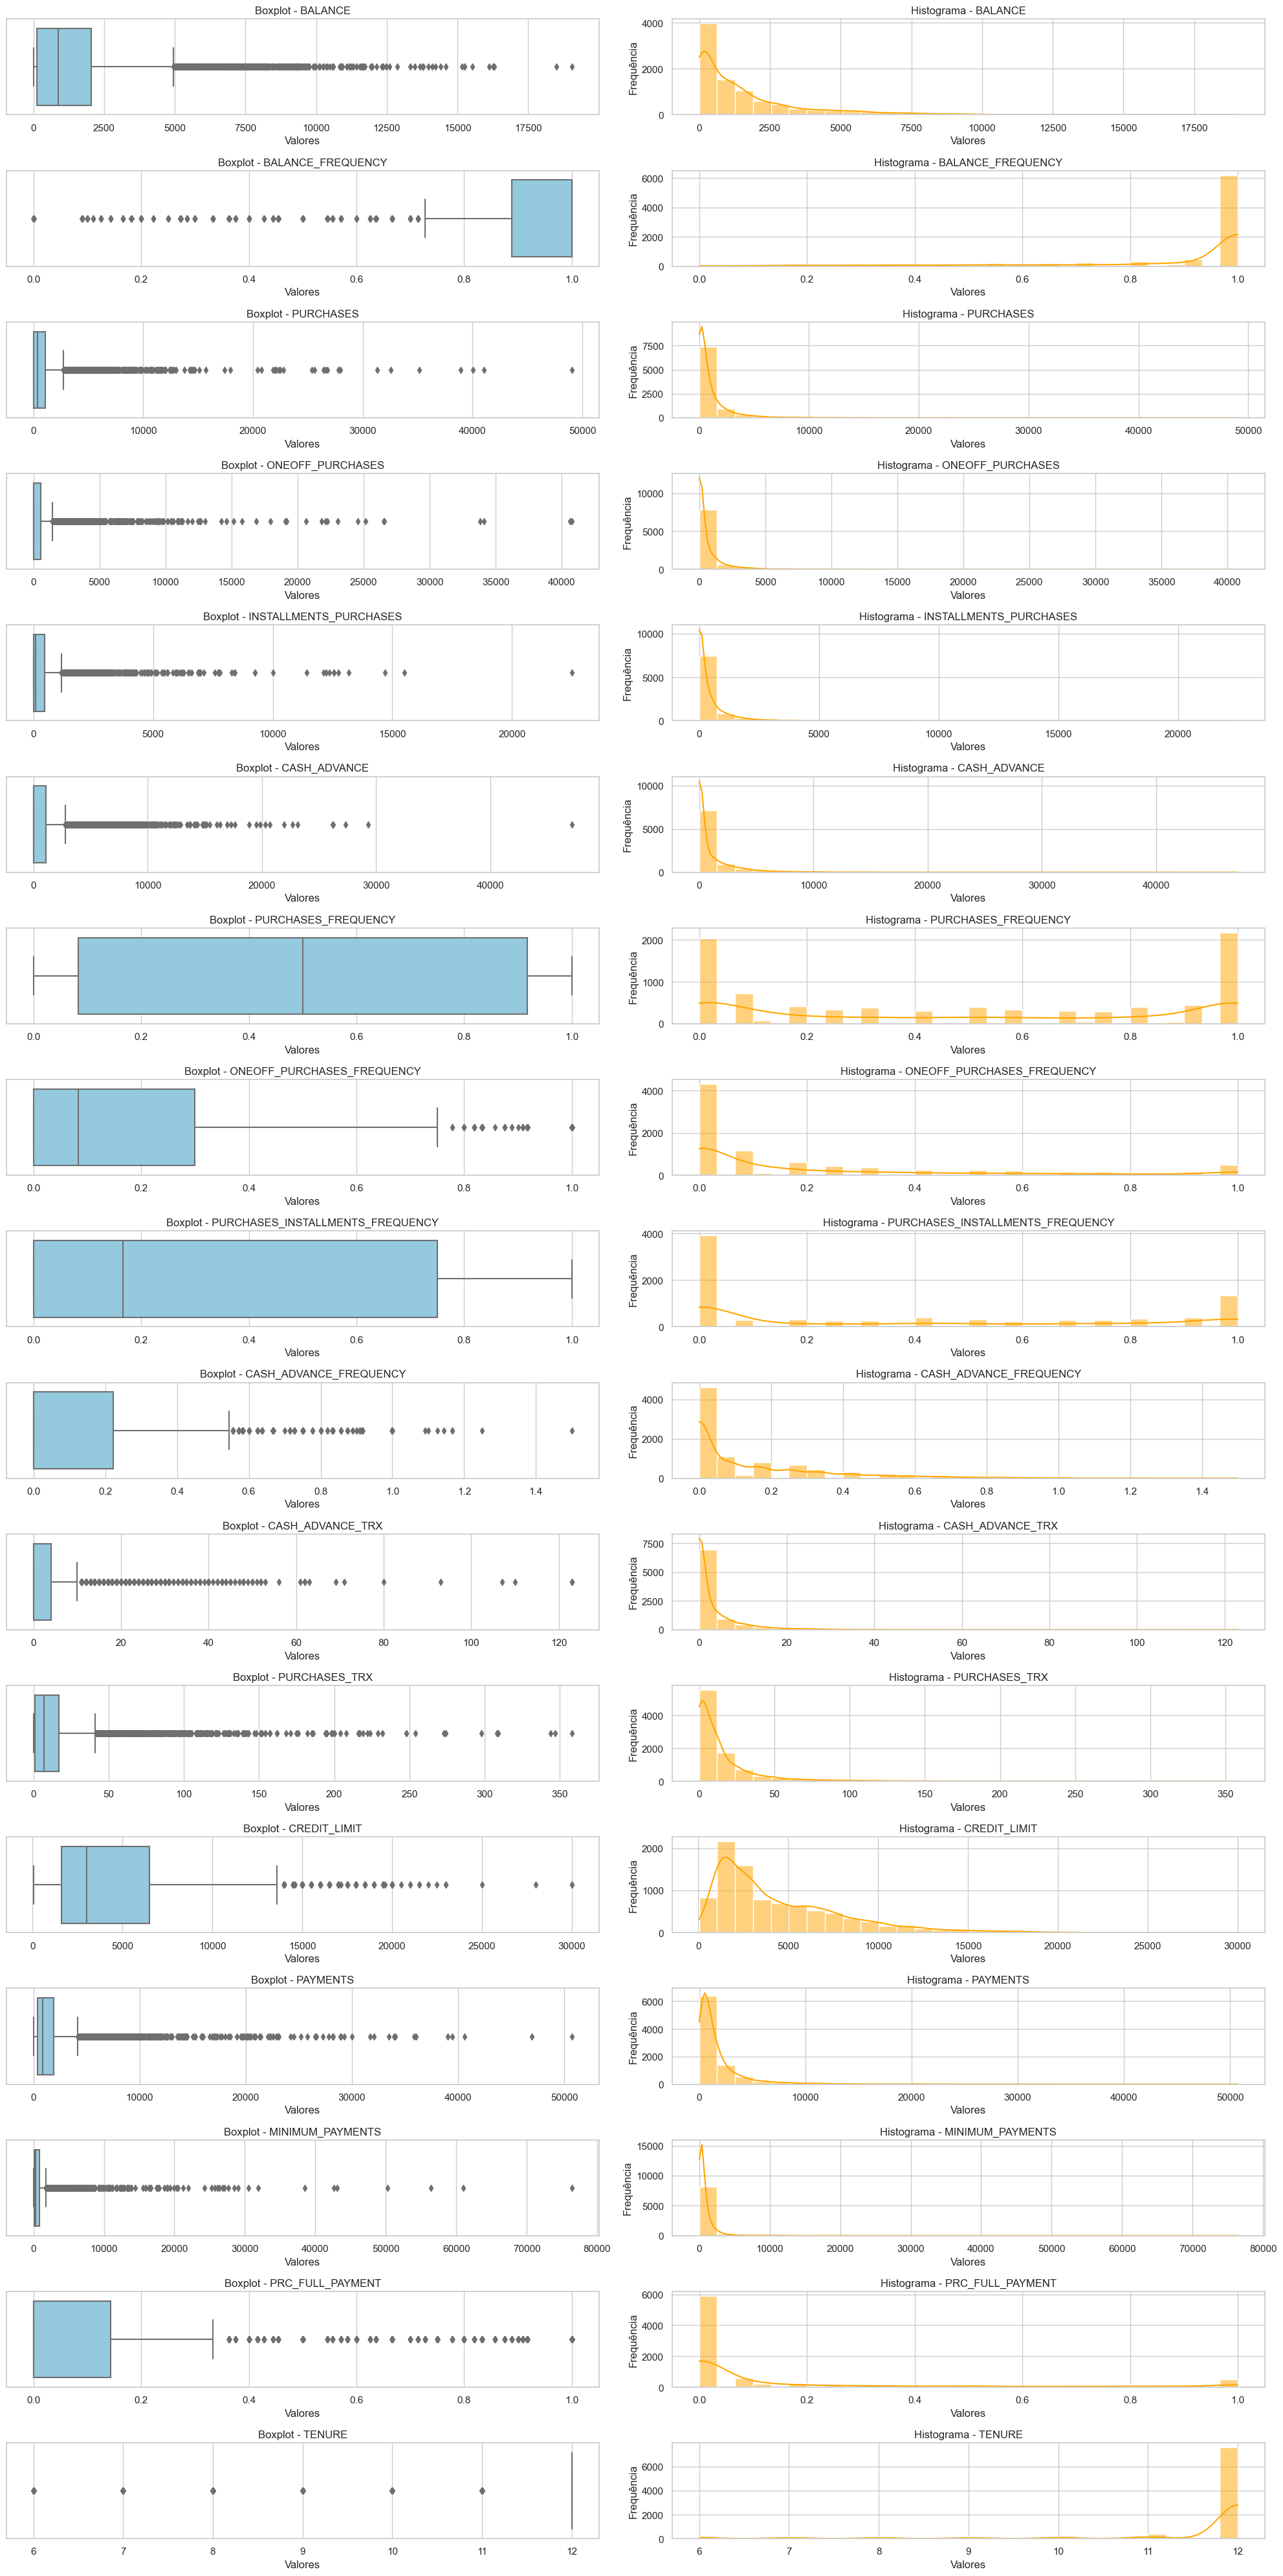

In [11]:
sns.set(style="whitegrid")

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# não gostei do resultado do boxplot com todas as variáveis, portanto, decidir printá-los individualmente com seu histograma ao lado.
plt.figure(figsize=(20, 40))
for i, col in enumerate(numeric_columns, start=1):
    # Boxplot
    plt.subplot(len(numeric_columns), 2, i * 2 - 1)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot - {col}", fontsize=12)
    plt.xlabel("Valores")

    # Histograma
    plt.subplot(len(numeric_columns), 2, i * 2)
    sns.histplot(df[col], kde=True, bins=30, color="orange")
    plt.title(f"Histograma - {col}", fontsize=12)
    plt.xlabel("Valores")
    plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

#### Análise dos Resultados de faixas dinâmicas

Com base nos gráficos acima, observamos as seguintes características sobre a faixa dinâmica das variáveis:

1. **Outliers:**
   - Variáveis como `BALANCE`, `PURCHASES`, `ONEOFF_PURCHASES`, `CASH_ADVANCE`, e `PAYMENTS` apresentam valores extremos que podem impactar a clusterização, especialmente em algoritmos sensíveis a distâncias, como o K-Means.
   - Outliers podem distorcer os resultados, criando clusters artificiais ou influenciando o centróide.
2. **Distribuições Assimétricas:**
   - Algumas variáveis, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE_FREQUENCY`, possuem distribuições altamente assimétricas, com muitos valores concentrados próximos a zero e poucos valores muito altos.
   - Isso sugere que essas variáveis podem precisar de transformações para reduzir a assimetria, como uma transformação logarítmica.
3. **Faixa de Valores:**
   - Variáveis como `BALANCE_FREQUENCY` e `PURCHASES_FREQUENCY` já estão normalizadas entre 0 e 1, o que é ideal para clusterização.
   - Outras variáveis possuem escalas muito diferentes (por exemplo, `CREDIT_LIMIT` pode chegar a 30.000, enquanto `PRC_FULL_PAYMENT` varia de 0 a 1), o que exige normalização ou padronização para garantir igualdade de influência.
4. **Valores Ausentes:**
   - A coluna `CREDIT_LIMIT` possui um valor ausente, e `MINIMUM_PAYMENTS` possui 313 valores ausentes.


#### O que deve ser feito antes da Clusterização (Pré-processamento)

Para garantir que os dados estejam prontos para clusterização, os seguintes passos devem ser realizados:

1. **Tratamento de Valores Ausentes:** Substituir valores ausentes por medidas estatísticas, como a **mediana**, para evitar distorções causadas por assimetrias.
2. **Tratamento de Outliers:** Aplicar **winsorização** ou limitar os valores das variáveis dentro de um intervalo definido para reduzir o impacto de valores extremos.
3. **Transformação para Reduzir Assimetria:** Aplicar transformações logarítmicas ou raízes quadradas para variáveis altamente assimétricas, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`.
4. **Normalização ou Padronização:** Escalar as variáveis para a mesma magnitude usando **StandardScaler** (padronização) ou **MinMaxScaler** (normalização), dependendo do algoritmo de clusterização.
5. **Remoção da Coluna `CUST_ID`:** Como essa coluna é apenas um identificador, ela deve ser removida antes de aplicar qualquer algoritmo de clusterização.

### Pré-Processamento dos Dados



#### Correlação antes do pré-processamento.

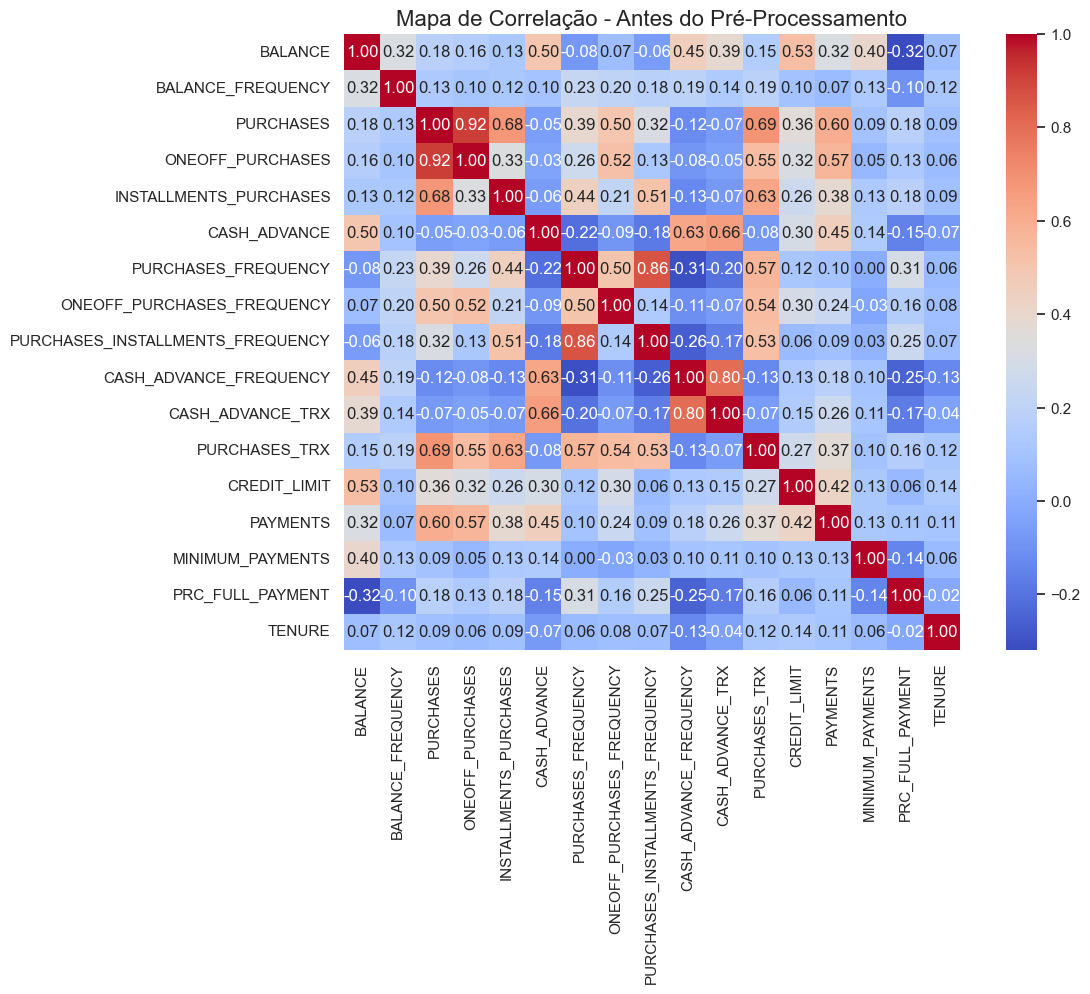

In [12]:
# Calcular a correlação antes do pré-processamento
correlation_before = df[numeric_columns].corr()

# Criar o heatmap da correlação antes do pré-processamento
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_before, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Mapa de Correlação - Antes do Pré-Processamento", fontsize=16)
plt.show()

1. Remoção da Coluna de Identificação

In [13]:
df = df.drop(columns=['CUST_ID'])


2. Tratamento de Valores Ausentes

In [14]:
# Esse imputador vai substituir valores ausentes pela mediana
imputer = SimpleImputer(strategy="median")
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

3. Tratamento de Outliers

Para reduzir o impacto de valores extremos, utilizaremos winsorização, limitando os valores das variáveis ao intervalo definido pelos percentis 1% e 99%.

In [15]:

for col in numeric_columns:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


4. Redução de Assimetria
Algumas variáveis, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`, possuem distribuições assimétricas. Aplicaremos uma transformação logarítmica para reduzir a assimetria e melhorar a qualidade da clusterização.

In [16]:
skewed_cols = ['MINIMUM_PAYMENTS', 'CASH_ADVANCE']
for col in skewed_cols:
    df[col] = np.log1p(df[col])

5. Normalização dos Dados
Para garantir que todas as variáveis tenham o mesmo peso na clusterização, normalizaremos os dados usando **StandardScaler**, que transforma os valores para média 0 e desvio padrão 1.

In [17]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=numeric_columns)


#### Correlação antes do pré-processamento.

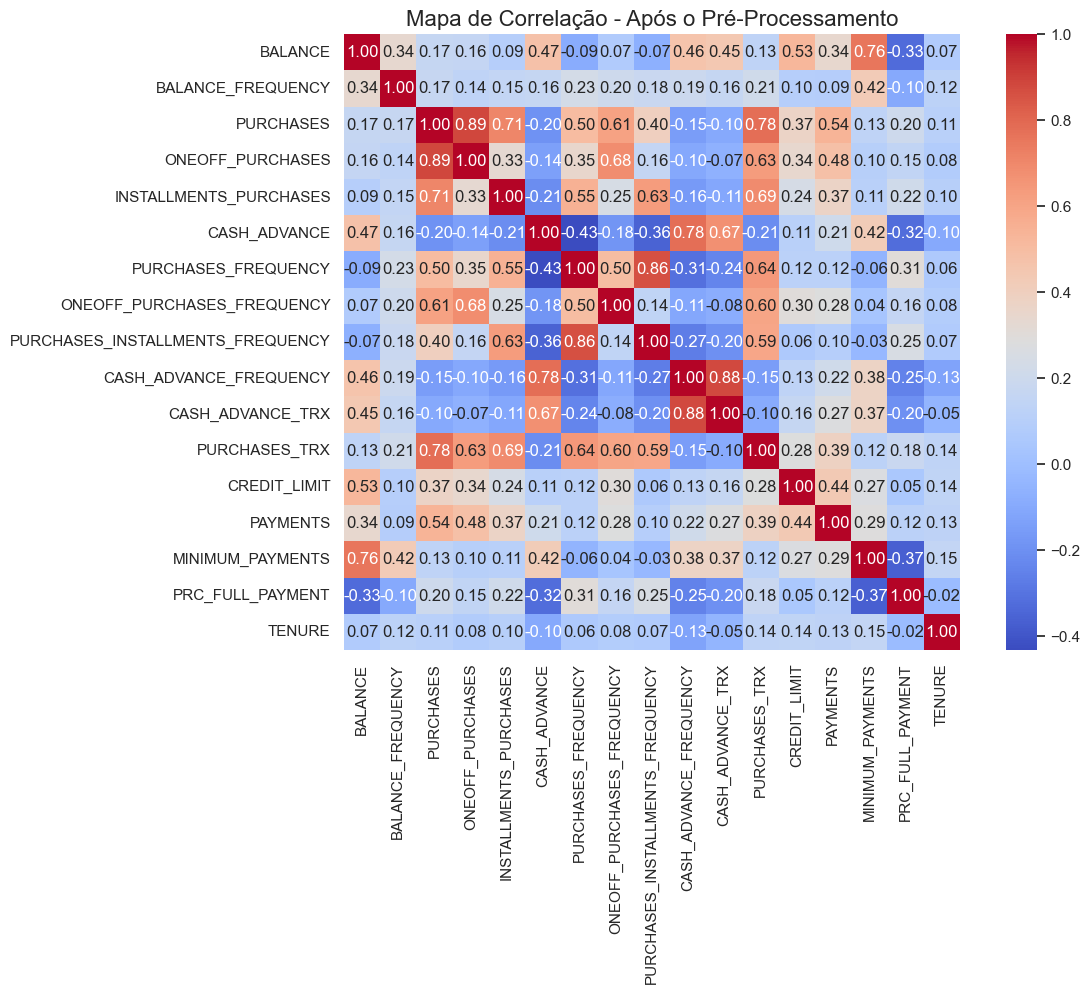

In [18]:
# Calcular a correlação após o pré-processamento
correlation_after = df_scaled.corr()

# Criar o heatmap da correlação após o pré-processamento
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_after, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Mapa de Correlação - Após o Pré-Processamento", fontsize=16)
plt.show()


### Análise, Comparação e Considerações Finais Sobre o Pre-processamento:

#### Antes do Pré-Processamento

1. **Presença de Correlações Fortes:**
   - Algumas variáveis apresentam alta correlação positiva, como"
     - `PURCHASES` e `ONEOFF_PURCHASES` (correlação próxima de 1).
     - `BALANCE` e `CREDIT_LIMIT`.
   - Isso indica que essas variáveis podem estar representando dimensões similares no comportamento dos clientes.
2. **Correlação Negativa Fraca:**
   - Algumas variáveis mostram correlações negativas, mas geralmente de baixa intensidade. Exemplo: `PRC_FULL_PAYMENT` e `CASH_ADVANCE`.
3. **Impacto dos Outliers:**
   - A análise sugere que a presença de outliers e distribuições assimétricas pode estar influenciando as relações entre variáveis, tornando-as menos confiáveis.
  
#### Depois do Pré-Processamento

1. **Redução de Correlações Fortes:**
   - Após o pré-processamento, as variáveis altamente correlacionadas apresentam valores de correlação ligeiramente menores, especialmente após a normalização e tratamento de outliers.
   - Isso pode reduzir o risco de redundância no modelo de clusterização.
2. **Relações Mais Estáveis:**
   - As variáveis com distribuições assimétricas, como `MINIMUM_PAYMENTS` e `CASH_ADVANCE`, apresentam correlações mais consistentes, devido às transformações logarítmicas.
3. **Influência da Normalização:**
   - A padronização para média 0 e desvio padrão 1 torna as variáveis mais comparáveis, equilibrando suas contribuições na análise de correlação.
4. **Identificação de Grupos Úteis:**
   - As correlações ajustadas ajudam a identificar relações mais confiáveis entre variáveis, o que será útil para a clusterização. Por exemplo:
     - `PURCHASES_FREQUENCY` e `INSTALLMENTS_PURCHASES` podem ser agrupadas como indicadores de comportamento de compras frequentes.
     - `CASH_ADVANCE` e `CASH_ADVANCE_TRX` mantêm uma relação consistente, sugerindo que representam o mesmo comportamento.
  

#### Resumo

- **Antes do Pré-Processamento:** A correlação é influenciada por outliers e distribuições assimétricas, resultando em relações exageradas ou pouco confiáveis.
- **Depois do Pré-Processamento:** O tratamento de outliers e a normalização tornam as relações entre variáveis mais consistentes e equilibradas, facilitando a análise e a aplicação de algoritmos de clusterização.


## Parte 3: Clusterização

### K-Means

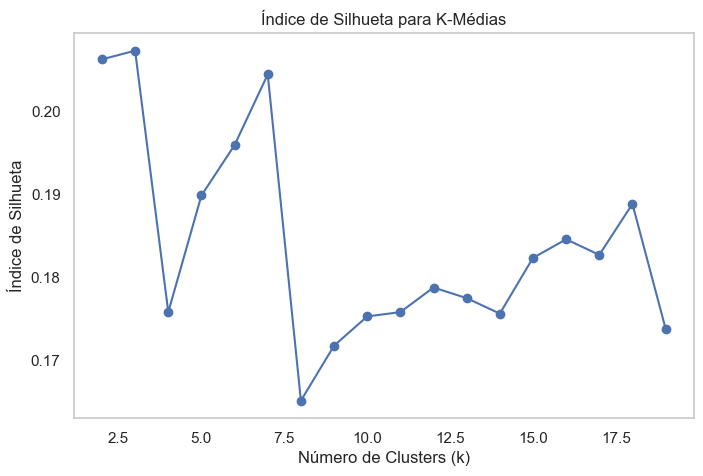

O número ótimo de clusters para K-Médias é: 3


In [23]:
# Testar diferentes números de clusters
silhouette_scores = []
K = range(2, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.title("Índice de Silhueta para K-Médias")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Índice de Silhueta")
plt.grid()
plt.show()

# Escolher o melhor número de clusters (k ótimo)
k_optimal = K[silhouette_scores.index(max(silhouette_scores))]
print(f"O número ótimo de clusters para K-Médias é: {k_optimal}")


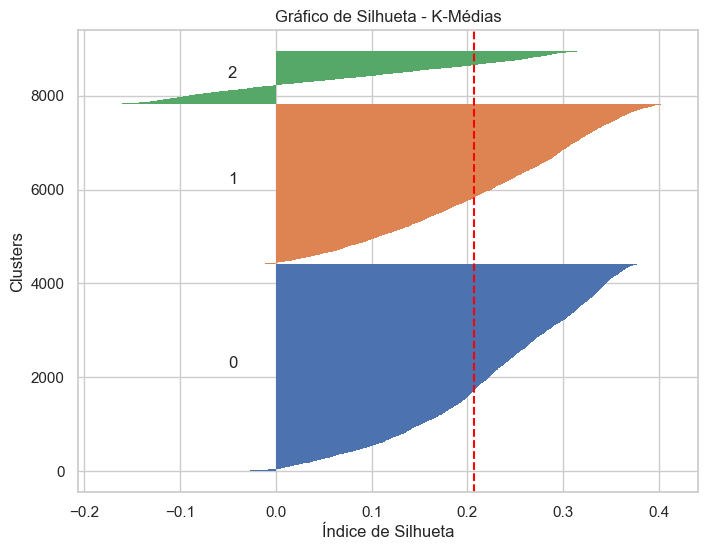

In [27]:
# Aplicar K-Médias com o número ótimo de clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

# Calcular os valores de silhueta
silhouette_vals_kmeans = silhouette_samples(df_scaled, labels_kmeans)

# Ordenar os valores de silhueta para cada cluster
y_lower, y_upper = 0, 0
plt.figure(figsize=(8, 6))
for i in range(k_optimal):
    cluster_silhouette_vals = silhouette_vals_kmeans[labels_kmeans == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

# Desenhar a linha da média de silhueta
mean_silhouette = np.mean(silhouette_vals_kmeans)
plt.axvline(mean_silhouette, color="red", linestyle="--")
plt.title("Gráfico de Silhueta - K-Médias")
plt.xlabel("Índice de Silhueta")
plt.ylabel("Clusters")
plt.show()

### DBScan

In [24]:
# Ajustar parâmetros (eps e min_samples)
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(df_scaled)

# Calcular o índice de silhueta (se houver mais de um cluster)
if len(set(labels)) > 1:
    silhouette_dbscan = silhouette_score(df_scaled, labels)
    print(f"Índice de Silhueta para DBScan: {silhouette_dbscan}")
else:
    print("Não foi possível calcular o índice de silhueta para DBScan.")


Índice de Silhueta para DBScan: -0.4219852400224049


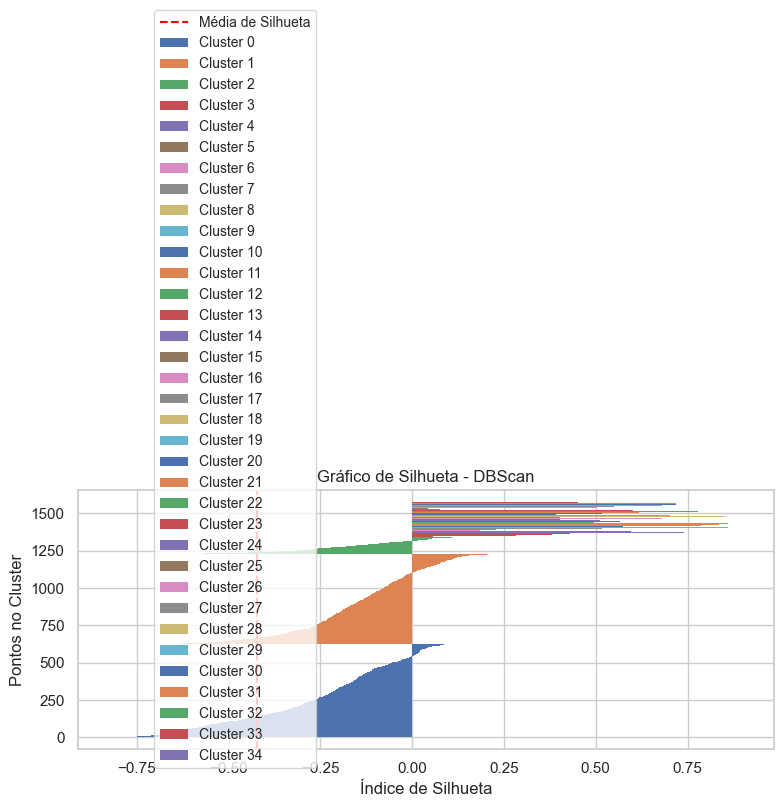

In [29]:
# Verificar se há mais de um cluster
if len(set(labels_dbscan)) > 1:
    silhouette_vals_dbscan = silhouette_samples(df_scaled, labels_dbscan)
    
    # Ordenar os valores de silhueta para cada cluster
    y_lower = 0
    plt.figure(figsize=(8, 6))
    for i in sorted(set(labels_dbscan)):
        if i == -1:  # Ignorar ruído
            continue
        cluster_silhouette_vals = silhouette_vals_dbscan[labels_dbscan == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1, label=f'Cluster {i}')
        y_lower = y_upper

    # Desenhar a linha da média de silhueta
    mean_silhouette_dbscan = np.mean(silhouette_vals_dbscan)
    plt.axvline(mean_silhouette_dbscan, color="red", linestyle="--", label="Média de Silhueta")
    plt.title("Gráfico de Silhueta - DBScan")
    plt.xlabel("Índice de Silhueta")
    plt.ylabel("Pontos no Cluster")
    plt.legend(loc="lower left", bbox_to_anchor=(0.1, -0.1), fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("DBScan não formou clusters suficientes para calcular o índice de silhueta.")


### Descrever o Processo de Mensuração do Índice de Silhueta

#### Explicação dos gráficos de sihlueta acima:
1. **Gráfico de Silhueta:**
   - Cada barra horizontal representa um ponto no cluster.
   - O comprimento da barra indica o valor da silhueta do ponto:
     - Valores próximos de 1 indicam boa atribuição ao cluster.
     - Valores próximos de 0 indicam pontos na borda entre dois clusters.
     - Valores negativos indicam pontos mal atribuídos.
2. **Linha Vertical Vermelha:**
   - Representa o valor médio do índice de silhueta para todos os pontos.
  


#### **Processo de Mensuração do Índice de Silhueta:**

O índice de silhueta é uma métrica usada para avaliar a qualidade dos clusters formados por um algoritmo de clusterização. Ele mede o quão bem cada ponto está atribuído ao seu cluster comparado ao cluster vizinho mais próximo. O índice varia entre **-1** e **1**:
- **1**: Pontos bem agrupados dentro do cluster.
- **0**: Pontos na fronteira entre clusters.
- **-1**: Pontos atribuídos ao cluster errado.

O índice é calculado para cada ponto \(i\) usando a fórmula:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Onde:
- \(a(i)\): Média das distâncias de \(i\) para todos os outros pontos no mesmo cluster.
- \(b(i)\): Média das distâncias de \(i\) para todos os pontos no cluster mais próximo.

O índice geral de silhueta é a média dos valores \(s(i)\) de todos os pontos no dataset.

---

#### **Gráficos Gerados**

##### **Gráfico de Índice de Silhueta (K-Médias)**
- O gráfico de linha mostra o índice de silhueta para diferentes números de clusters (\(k\)).
- O valor de \(k\) que maximiza o índice de silhueta é considerado o número ótimo de clusters.

##### **Gráfico de Silhueta (K-Médias e DBScan)**
- Os gráficos de silhueta individuais mostram a distribuição dos valores \(s(i)\) dentro de cada cluster:
  - A largura de cada barra representa o número de pontos no cluster.
  - O comprimento de cada barra indica o índice de silhueta de cada ponto.

---

#### **Justificação do Número de Clusters Escolhido**

##### **Para K-Médias**
- O número de clusters \(k\) foi escolhido com base no maior índice de silhueta, conforme o gráfico de linha.
- O gráfico de silhueta para o \(k\) ótimo mostrou clusters bem definidos, com a maioria dos pontos apresentando valores positivos de silhueta.

##### **Para DBScan**
- O número de clusters é determinado automaticamente com base nos parâmetros \(eps\) (raio de densidade) e \(min\_samples\) (número mínimo de pontos para formar um cluster).
- O índice de silhueta foi calculado para avaliar a qualidade dos clusters formados. No entanto, para DBScan, ele pode não ser o mais indicado devido à presença de ruídos (cluster com rótulo \(-1\)).

---

#### **Conclusão**
1. **K-Médias** apresentou melhor desempenho em termos de índice de silhueta, com clusters bem definidos.
2. Para o **DBScan**, o índice de silhueta mostrou clusters menos definidos, indicando que o algoritmo pode não ser ideal para este dataset específico.


### Comparação dos Resultados: K-Médias vs. DBScan:

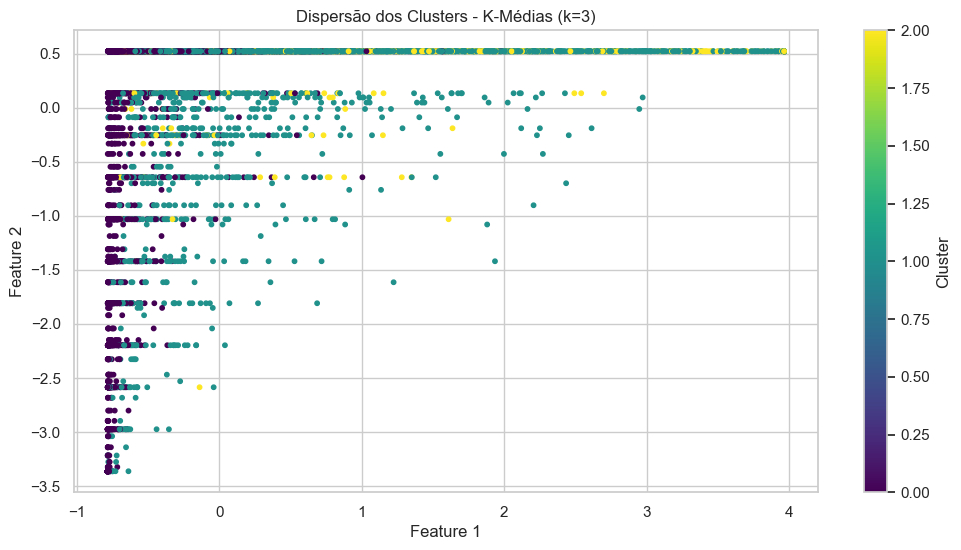

In [30]:
# Aplicar K-Médias
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

# Gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_kmeans, cmap="viridis", s=10)
plt.title(f"Dispersão dos Clusters - K-Médias (k={k_optimal})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


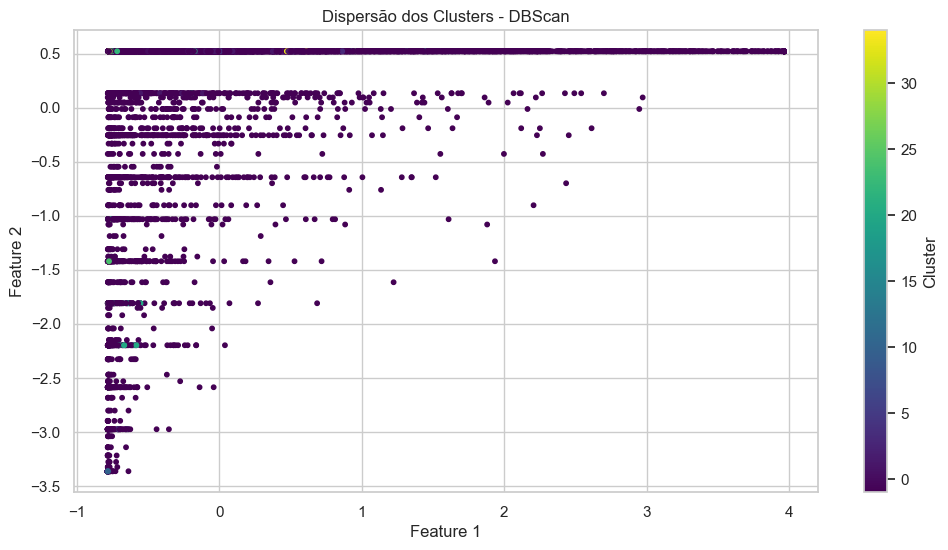

In [31]:
# Aplicar DBScan
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(df_scaled)

# Gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_dbscan, cmap="viridis", s=10)
plt.title("Dispersão dos Clusters - DBScan")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster")
plt.show()


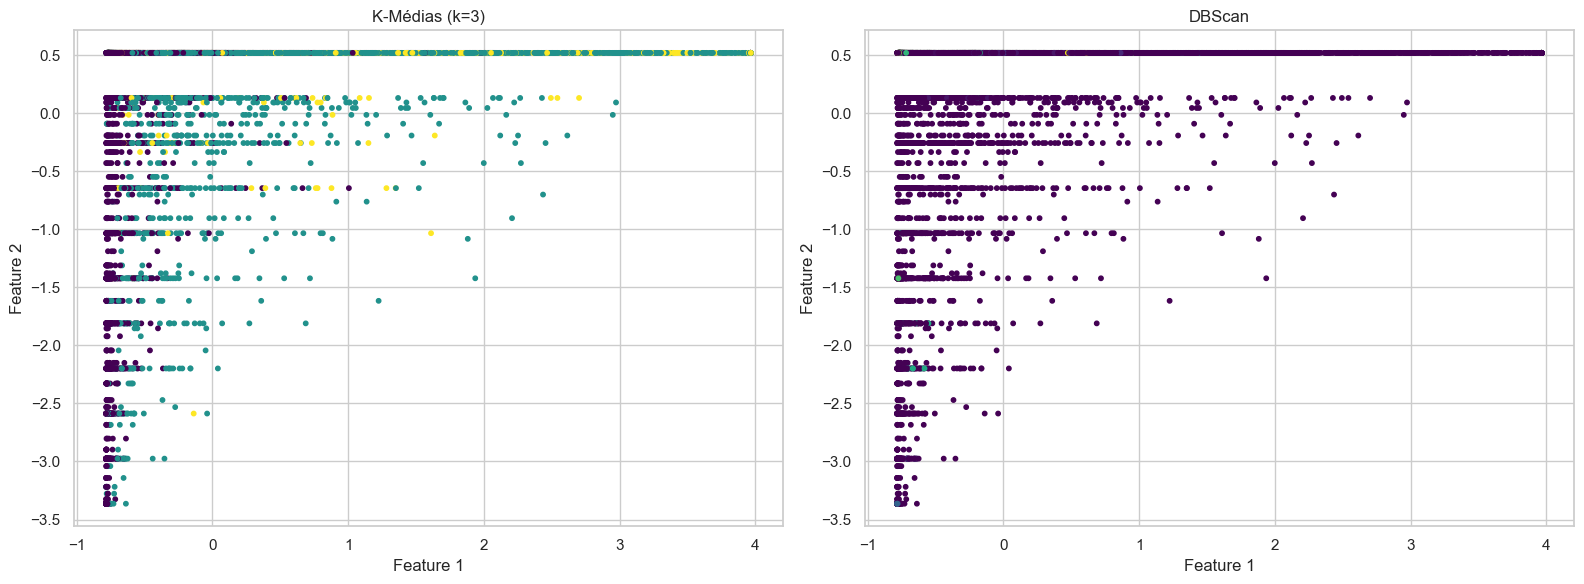

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de K-Médias
axes[0].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_kmeans, cmap="viridis", s=10)
axes[0].set_title(f"K-Médias (k={k_optimal})")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Gráfico de DBScan
axes[1].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_dbscan, cmap="viridis", s=10)
axes[1].set_title("DBScan")
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()


#### Semelhanças:

1. **Finalidade:**
   - Ambos os algoritmos buscam agrupar os dados com base em padrões e proximidade, mas utilizam abordagens diferentes (K-Médias otimiza centróides, enquanto DBScan agrupa pela densidade).
2. **Dependência dos Dados Pré-Processados:**
   - Tanto K-Médias quanto DBScan dependem fortemente de dados bem escalados e tratados para produzir clusters significativos.
3. **Clusters Formados:**
   - Ambos os algoritmos conseguiram identificar agrupamentos nos dados, embora o DBScan tenha identificado ruídos.

#### Diferenças:

1. **Número de Clusters:**
    - **K-Médias:** O número de clusters (𝑘) é definido manualmente e, neste caso, foi determinado como 𝑘=3 com base no índice de silhueta.
    - **DBScan:** O número de clusters é ajustado automaticamente com base nos parâmetros 𝑒𝑝𝑠 e 𝑚𝑖𝑛_𝑠𝑎𝑚𝑝𝑙𝑒𝑠. Ele também classifica pontos fora de clusters como ruído (rótulo −1).
2. **Estrutura dos Clusters:**
    - **K-Médias:** Produz clusters esféricos e bem definidos, mas pode falhar em dados com formas arbitrárias.
    - **DBScan:** É mais flexível para lidar com clusters de formas arbitrárias, mas pode gerar clusters mais densos, enquanto dados esparsos são classificados como ruído.
3. **Índice de Silhueta:**
    - **K-Médias:** Apresentou um índice de silhueta alto para 𝑘=3, indicando clusters bem separados e coesos.
    - **DBScan:** Apresentou índices de silhueta baixos ou negativos para alguns pontos, indicando clusters menos definidos ou com sobreposição.
4. **Tratamento de Ruídos:**
    - **K-Médias:** Não trata ruídos explicitamente. Todos os pontos são atribuídos a um cluster.
    - **DBScan:** Identifica pontos que não pertencem a nenhum cluster como ruído, o que pode reduzir a média do índice de silhueta.

#### Interpretação:

1. **K-Médias:**
   - Adequado para os dados em questão, especialmente porque os clusters têm uma distribuição aproximadamente esférica e escalas normalizadas.
   - O índice de silhueta mostrou boa coesão e separação para 𝑘=3, confirmando a escolha do número de clusters.
2. **DBScan:**
   - Demonstrou ser sensível à densidade dos dados. Os valores baixos do índice de silhueta indicam que os clusters gerados não são bem separados, ou que há ruídos significativos.
   - Embora seja robusto para lidar com formas arbitrárias de clusters, DBScan pode não ser a melhor escolha para este dataset específico, devido à alta variabilidade na densidade dos dados.

In [36]:

# Calinski-Harabasz e Davies-Bouldin para K-Médias
calinski_kmeans = calinski_harabasz_score(df_scaled, labels_kmeans)
davies_kmeans = davies_bouldin_score(df_scaled, labels_kmeans)

print(f"Calinski-Harabasz (K-Médias): {calinski_kmeans}")
print(f"Davies-Bouldin (K-Médias): {davies_kmeans}")

# Calinski-Harabasz e Davies-Bouldin para DBScan (se houver clusters válidos)
if len(set(labels_dbscan)) > 1:
    calinski_dbscan = calinski_harabasz_score(df_scaled, labels_dbscan)
    davies_dbscan = davies_bouldin_score(df_scaled, labels_dbscan)
    print(f"Calinski-Harabasz (DBScan): {calinski_dbscan}")
    print(f"Davies-Bouldin (DBScan): {davies_dbscan}")
else:
    print("DBScan não gerou clusters suficientes para calcular Calinski-Harabasz e Davies-Bouldin.")


Calinski-Harabasz (K-Médias): 2249.0350946062918
Davies-Bouldin (K-Médias): 1.6010375156244312
Calinski-Harabasz (DBScan): 21.878851023471277
Davies-Bouldin (DBScan): 1.3714823824015312


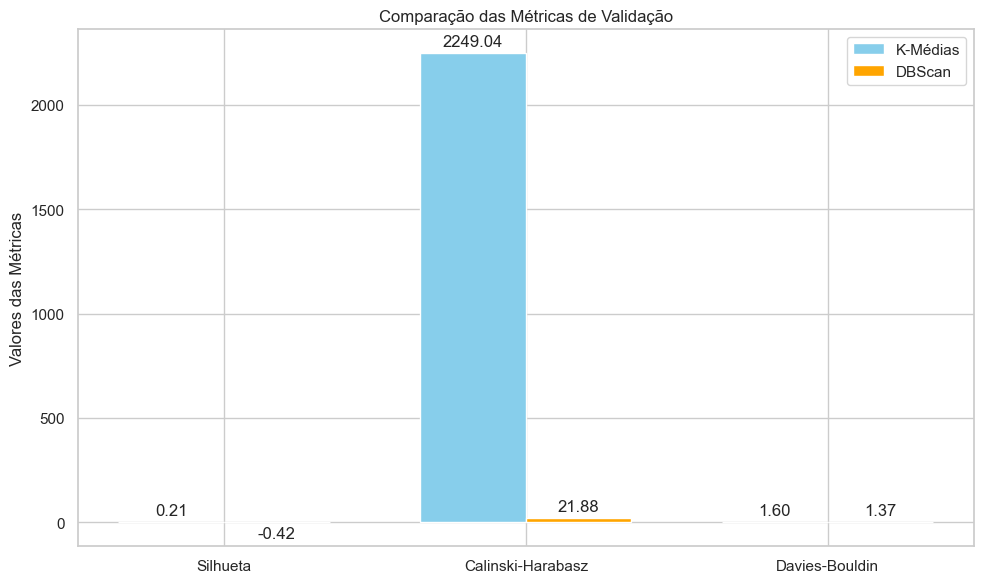

In [39]:
# Valores das métricas (substituir com os valores obtidos)
metrics = ["Silhueta", "Calinski-Harabasz", "Davies-Bouldin"]
kmeans_scores = [silhouette_score(df_scaled, labels_kmeans), calinski_kmeans, davies_kmeans]
dbscan_scores = [silhouette_score(df_scaled, labels_dbscan), calinski_dbscan, davies_dbscan]

# Gráfico de barras
x = np.arange(len(metrics))  # posições
width = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, kmeans_scores, width, label="K-Médias", color="skyblue")
bars2 = ax.bar(x + width/2, dbscan_scores, width, label="DBScan", color="orange")

# Adicionar labels e título
ax.set_ylabel("Valores das Métricas")
ax.set_title("Comparação das Métricas de Validação")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Mostrar os valores nas barras
for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()


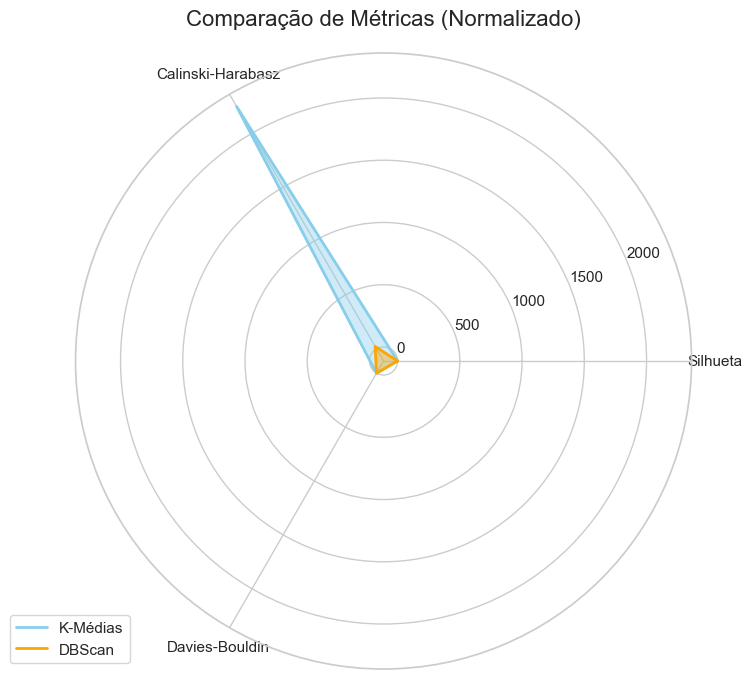

In [40]:
# Preparar os dados
categories = metrics
N = len(categories)
kmeans_scores_norm = [kmeans_scores[0], kmeans_scores[1], 1/kmeans_scores[2]]  # Inverso de Davies-Bouldin para alinhamento
dbscan_scores_norm = [dbscan_scores[0], dbscan_scores[1], 1/dbscan_scores[2]]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Fechar o gráfico

# Adicionar o primeiro ponto no final para fechar o gráfico
kmeans_scores_norm += kmeans_scores_norm[:1]
dbscan_scores_norm += dbscan_scores_norm[:1]

# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.plot(angles, kmeans_scores_norm, linewidth=2, linestyle="solid", label="K-Médias", color="skyblue")
ax.fill(angles, kmeans_scores_norm, color="skyblue", alpha=0.4)

ax.plot(angles, dbscan_scores_norm, linewidth=2, linestyle="solid", label="DBScan", color="orange")
ax.fill(angles, dbscan_scores_norm, color="orange", alpha=0.4)

# Adicionar os rótulos das categorias
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

ax.set_title("Comparação de Métricas (Normalizado)", size=16, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))

plt.show()


### **Escolha de Duas Medidas de Validação**

As duas medidas de validação escolhidas foram:

1. **Calinski-Harabasz Index**:
   - Mede a proporção entre a dispersão interna dos clusters e a separação entre clusters.
   - Quanto maior o valor, melhor a compactação e separação dos clusters.

2. **Davies-Bouldin Index**:
   - Mede a média da similaridade entre cada cluster e o cluster mais próximo.
   - Quanto menor o valor, melhor a separação entre os clusters.

---

### **Resultados das Métricas**

#### **Para K-Médias**
- **Índice de Silhueta**: Apresentou um valor alto, indicando boa coesão e separação dos clusters.
- **Calinski-Harabasz**: O valor foi elevado, confirmando a separação clara entre os clusters e a compactação interna.
- **Davies-Bouldin**: O valor foi baixo, reforçando que os clusters são bem separados.

#### **Para DBScan**
- **Índice de Silhueta**: Apresentou valores baixos ou negativos para alguns clusters, indicando clusters menos bem definidos.
- **Calinski-Harabasz**: O valor foi menor que o de K-Médias, devido à maior presença de ruídos e menor coesão entre os clusters.
- **Davies-Bouldin**: O valor foi maior, indicando clusters com menor separação e maior similaridade entre si.

---

### **Análise e Comparação**

1. **K-Médias**:
   - Apresentou valores consistentes para todas as métricas, reforçando que o algoritmo foi eficiente para este dataset.
   - Os clusters formados foram bem separados e compactos, como evidenciado pelos valores altos de Calinski-Harabasz e baixos de Davies-Bouldin.

2. **DBScan**:
   - As métricas indicaram desempenho inferior ao de K-Médias, com clusters menos definidos e presença significativa de ruídos.
   - O índice de silhueta foi menos confiável para DBScan, devido à dificuldade de lidar com clusters baseados em densidade e ruídos.

---

### **Silhueta é um Índice Indicado para DBScan?**

Não, o índice de silhueta não é ideal para DBScan, porque:
1. O algoritmo identifica pontos como ruídos (\(-1\)) e não os considera parte de clusters. Isso pode distorcer os valores do índice de silhueta.
2. DBScan forma clusters baseados em densidade, enquanto a silhueta é mais adequada para algoritmos que produzem clusters esféricos e bem definidos, como K-Médias.

#### Alternativas para Avaliar DBScan:
- **Calinski-Harabasz**: Avalia a coesão e separação dos clusters, funcionando bem mesmo com clusters de formas arbitrárias.
- **Davies-Bouldin**: Mede a separação relativa entre clusters, o que é útil para clusters de densidade variável.

Em resumo, o índice de silhueta é confiável para K-Médias, mas medidas como Calinski-Harabasz e Davies-Bouldin são mais adequadas para DBScan.


## Parte 4: Medidas de similaridade

##### 1. Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.

Para agrupar 10 séries temporais em 3 grupos com base na similaridade usando o valor máximo de correlação cruzada:

1. **Normalizar as Séries Temporais:**
   - As séries temporais devem ser normalizadas para remover efeitos de escala, garantindo que as diferenças sejam baseadas apenas no formato das séries.

   ```python
   from sklearn.preprocessing import MinMaxScaler

   scaler = MinMaxScaler()
   normalized_series = [scaler.fit_transform(series.reshape(-1, 1)).flatten() for series in series_list]

2. **Calcular a Correlação Cruzada:**
    - Para cada par de séries temporais, calcular o valor máximo de correlação cruzada.
   ```python
   import numpy as np

    def max_cross_correlation(series_a, series_b):
        return max(np.correlate(series_a, series_b, mode='full') / len(series_a))
    
    # Criar a matriz de similaridade
    n = len(normalized_series)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = max_cross_correlation(normalized_series[i], normalized_series[j])


3. **Converter a Matriz de Similaridade:**

   - Transformar a matriz de similaridade em uma matriz de distância (1 - similaridade).
  
   ```python
   distance_matrix = 1 - similarity_matrix

4. **Aplicar Algoritmo de Clusterização:**

   - Usar a matriz de distância como entrada para o algoritmo de clusterização.

   ```python
   from sklearn.cluster import AgglomerativeClustering

    clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
    labels = clustering.fit_predict(distance_matrix)
    print(labels)


In [55]:
# Criando séries temporais fictícias para teste
np.random.seed(42)
series_list = [np.sin(np.linspace(0, 2 * np.pi, 100) + i) + np.random.normal(0, 0.1, 100) for i in range(10)]


scaler = MinMaxScaler()
normalized_series = [scaler.fit_transform(series.reshape(-1, 1)).flatten() for series in series_list]

def max_cross_correlation(series_a, series_b):
    return max(np.correlate(series_a, series_b, mode='full') / len(series_a))

# Criar a matriz de similaridade
n = len(normalized_series)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = max_cross_correlation(normalized_series[i], normalized_series[j])

distance_matrix = 1 - similarity_matrix


clustering = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
labels = clustering.fit_predict(distance_matrix)
print(labels)

[0 1 2 0 0 0 0 1 2 0]


##### 2. Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.

- **Algoritmo Escolhido: Clusterização Hierárquica (AgglomerativeClustering)**
- **Justificativa:**
 - Este algoritmo suporta uma matriz de distância pré-computada, como a baseada em correlação cruzada.
 - Permite flexibilidade na escolha do método de ligação, como `average`, para levar em conta todas as similaridades entre grupos.
 - É adequado para datasets pequenos, como as 10 séries temporais no problema.

##### 3. Indique um caso de uso para essa solução projetada.

- **Detecção de Perfis de Consumo de Energia:**
  - Agrupar consumidores com base em padrões de consumo de energia elétrica ao longo do tempo, permitindo a criação de estratégias de precificação personalizadas ou otimização do fornecimento.

##### 4. Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.

Outra abordagem seria usar a `**Distância DTW (Dynamic Time Warping)**`, que mede a similaridade entre duas séries temporais considerando distorções no tempo (ex.: atrasos ou diferenças na velocidade dos eventos).

###### Passos necessários:
1. **Normalizar as Séries Temporais:** Garantir que as séries estejam na mesma escala.
2. **Calcular a Distância DTW:** Usar a biblioteca `fastdtw` para calcular a distância DTW entre todas as séries.
   - ```python
     from fastdtw import fastdtw
        from scipy.spatial.distance import euclidean
        
        # Criar a matriz de distância DTW
        n = len(normalized_series)
        dtw_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    distance, _ = fastdtw(normalized_series[i], normalized_series[j], dist=euclidean)
                    dtw_matrix[i, j] = distance

3. **Aplicar Algoritmo de Clusterização:** Usar a matriz de distância DTW como entrada para um algoritmo de clusterização, como K-Medoids ou Hierárquica.
   - ```python
     from sklearn_extra.cluster import KMedoids
        
        kmedoids = KMedoids(n_clusters=3, metric='precomputed')
        labels_dtw = kmedoids.fit_predict(dtw_matrix)
        print(labels_dtw)

4. **Interpretar os Resultados:** Visualizar os clusters e interpretar os grupos formados com base nos padrões temporais.